In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.optimize import differential_evolution, curve_fit, dual_annealing

In [ ]:
# Pobierz czcionkę z Google Fonts (lub bezpośrednio z innego źródła)
!wget -O THSarabunNew.ttf https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf

# Utwórz katalog fonts i przenieś tam font
!mkdir -p ~/.fonts
!mv THSarabunNew.ttf ~/.fonts/

# Przeładuj fonty w systemie
import matplotlib.font_manager as fm
fm.fontManager.addfont("/root/.fonts/THSarabunNew.ttf")

--2025-06-21 18:23:41--  https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/fonts/main/ofl/sarabun/Sarabun-Regular.ttf [following]
--2025-06-21 18:23:41--  https://raw.githubusercontent.com/google/fonts/main/ofl/sarabun/Sarabun-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90220 (88K) [application/octet-stream]
Saving to: ‘THSarabunNew.ttf’

THSarabunNew.ttf    100%[===================>]  88.11K  --.-KB/s    in 0.02s   

2025-06-21 18:23:41 (3.60 MB/s) - ‘THSarabunNew.ttf’ saved [90220/90220]



In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Global settings for plotting

## Font
rcParams['font.family'] = 'Sarabun'
rcParams['font.size'] = 14

## Lines
rcParams['lines.solid_joinstyle'] = 'miter'  # other options: 'round' or 'bevel'
rcParams['lines.antialiased'] = True  # turning on/off of antialiasing for sharper edges
rcParams['lines.linewidth'] = 1.25

## Legend
rcParams['legend.loc'] = 'upper left'
rcParams['legend.frameon'] = False

## Ticks
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True

rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True

## Resolution
rcParams['figure.dpi'] = 150

## Global color
rcParams['image.cmap'] = "viridis"

## Colors
### Palettes from color-hex.com/
c_google = ['#008744', '#0057e7', '#d62d20', '#ffa700'] # G, B, R, Y # https://www.color-hex.com/color-palette/1872
c_twilight = ['#363b74', '#673888', '#ef4f91', '#c79dd7', '#4d1b7b'] # https://www.color-hex.com/color-palette/809

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Nano_projekt'

Cu_dir = os.path.join(data_dir, 'Nb_Cu')
Fe_dir = os.path.join(data_dir, 'Nb_Fe')

print(Cu_dir)
print(Fe_dir)

Mounted at /content/drive
/content/drive/MyDrive/Nano_projekt/Nb_Cu
/content/drive/MyDrive/Nano_projekt/Nb_Fe


In [ ]:
def load_data(name, folder=Cu_dir):
    path = os.path.join(folder, name)
    data = np.loadtxt(path, delimiter=',')
    V_mV, G = data[:,0], data[:,1]
    return V_mV*1e-3, G

# **BTK**

In [ ]:
# na podstawie tabelki z ref1 str. 25

def btk_reflection_probs(E, Z, Delta):
    # E_c = E + 1j*Gamma                  # Gamma - rozmycie
    # xi = np.sqrt(E_c**2 - Delta**2)
    # u0 = 0.5*(1 + xi/E_c)               # kwadrat
    # v0 = 1 - u0                         # kwadrat

    # a = u0 + Z**2*(u0 - v0)
    # b = Z*np.sqrt(u0 - v0)
    # den = np.abs(a)**2 # + np.abs(b)**2
    # A = (u0*v0)/den
    # B = (np.abs(b)**2)/den

    # return np.real(A), np.real(B)

    A = np.zeros_like(E)
    B = np.zeros_like(E)
    Bp = np.zeros_like(E)
    for i, Ei in enumerate(E):
        if Ei <= Delta:
            A[i] = Delta**2 / (Ei**2 + (Delta**2 - Ei**2) * (1 + 2*Z**2)**2)
            B[i] = 1 - A[i]
            Bp[i] = 1
        else:
            u0 = 0.5 * (1 + np.sqrt(Ei**2 - Delta**2) / Ei)
            v0 = 1 - u0
            gamma = (u0 + Z**2 * (u0 - v0))**2
            A[i] = u0 * v0 / gamma
            B[i] = ((u0 - v0)**2 * Z**2 * (1 + Z**2)) / (gamma)
            # Bp[i] = B[i]/(1 - A[i])
            Bp[i] = (Z**2*(1+Z**2)) / (u0+Z**2+(u0-v0)*Z**2*(1+Z**2))
    return A, B, Bp

In [ ]:
def fermi_dirac(E, G):
    kB = 8.617e-5  # Boltzmann [eV/K]
    T = 1.5 #4.2       # temperatura [K]
    # kernel splotu = -d f(E)/dE = 1/(4 kB T) sech^2(E/(2 kB T))
    dE = E[1] - E[0]
    kernel = (1/(4 * kB * T)) * (1/np.cosh(E/(2 * kB * T)))**2
    # normalizacja kernelu
    kernel /= np.sum(kernel) * dE
    G_therm = np.convolve(G, kernel, mode='same') * dE
    return G_therm

In [ ]:
def polarized_conductance(V, Z, Delta, P, perc, therm):
    E = np.abs(V)
    A, B, Bp = btk_reflection_probs(E, Z, Delta)
    G_up = 1 + A - B
    G_pol = 1 - Bp
    G = (1 - P)*G_up + P*G_pol

    if therm:
      G_therm = fermi_dirac(E, G)

      n = len(G)
      cut = int(perc * n)

      G_new = np.array(G, copy=True)

      G_new[cut : n - cut] = G_therm[cut : n - cut]
    else:
      G_new = G

    return G_new

In [ ]:
def global_guess(V, G, therm):
    bounds = [
      (0, 5), # wymuszamy Z >= 1e-3, aby uniknąć rozwiązania Z=0
      (0, 3e-3), # Delta
      (0, 1),     # P
      (0.1, 0.25) # procent do rozmycia
      ]
    def loss(params):
        Z, D, P, perc = params
        Gmod = polarized_conductance(V, Z, D, P, perc, therm)
        print(f"Error val: {np.sum((Gmod - G)**2)}\n")
        return np.sum((Gmod - G)**2)
    res = differential_evolution(loss, bounds, tol=1e-6)
    # res = dual_annealing(loss, bounds)
    return res.x

In [ ]:
def fit_btk(name, folder=Cu_dir, therm=False):
    V, G = load_data(name, folder)
    # globalne zgadywanie parametrów
    Z0, D0, P0, perc0 = global_guess(V, G, therm)
    print(f'Global guess: Z={Z0:.3f}, Δ={D0*1e3:.2f} mV, P={P0:.3f}, mix%={perc0:.3f}')

    # lokalne dopasowanie Levenberg–Marquardt z curve_fit
    p0 = [Z0, D0, P0, perc0]
    lower = [0, 0, 0, 0.1]
    upper = [5, 3e-3, 1, 0.25]
    popt, cov = curve_fit(lambda V, Z, D, P, perc: polarized_conductance(V, Z, D, P, perc, therm),
                           V, G, p0=p0, bounds=(lower, upper))
    Zf, Df, Pf, percf = popt
    print(f'Fit final: Z={Zf:.3f}, Δ={Df*1e3:.2f} mV, P={Pf:.3f}, mix%={percf:.3f}')

    Gfit = polarized_conductance(V, Zf, Df, Pf, percf, therm)
    if therm==False:
        percf = 0
    plt.figure(figsize=(6,4))
    plt.plot(V*1e3, G, 'o', ms=2, label='data', color='k')
    plt.plot(V*1e3, Gfit, '-', lw=2, label='fit', color='tab:red', linestyle='--')
    plt.xlabel('V [mV]')
    plt.ylabel('G (normalized)')
    plt.legend(loc='best')
    plt.title(f'{folder[-5:]}: {name}\n Fit final: Z={Zf:.3f}, Δ={Df*1e3:.2f} mV, P={Pf:.3f}, mix%={percf*100:.0f}')
    plt.tight_layout()


    return popt

Global guess: Z=0.079, Δ=1.53 mV, P=0.513, mix%=0.143
Fit final: Z=0.079, Δ=1.53 mV, P=0.513, mix%=0.143


/tmp/ipython-input-34-3906810996.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(V*1e3, Gfit, '-', lw=2, label='fit', color='tab:red', linestyle='--')


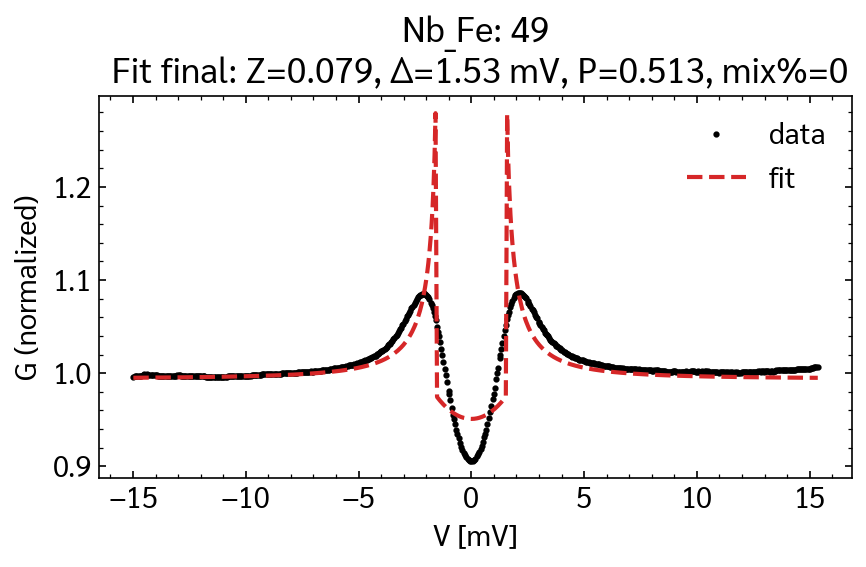

array([0.07901376, 0.00152993, 0.51260174, 0.14266379])

In [ ]:
fit_btk('49', Fe_dir)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Error val: 0.234282535793277

Error val: 0.17775669985445827

Error val: 0.17831252981842194

Error val: 0.1785801483106651

Error val: 0.2308275156666463

Error val: 0.1781859850576486

Error val: 0.1780110989904241

Error val: 0.17788179344754818

Error val: 0.17730512135471072

Error val: 0.17791505276576866

Error val: 0.17782068843648247

Error val: 0.17723064730360974

Error val: 0.18484290676485665

Error val: 0.17743872447790626

Error val: 0.1775079187265139

Error val: 0.17734177710606536

Error val: 0.1780072990812509

Error val: 0.17830226479035038

Error val: 0.17780537243108807

Error val: 0.17771888645934183

Error val: 0.17754581326378735

Error val: 0.17754181700675942

Error val: 0.23520015996237484

Error val: 0.17732701254674998

Error val: 0.23744736687901136

Error val: 0.17811377421506908

Error val: 0.2346769934632147

Error val: 0.17764626063355626

Error val: 0.1776487749743882

Error val: 0.1772

/tmp/ipython-input-10-984199548.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(V*1e3, Gfit, '-', lw=2, label='fit', color='tab:red', linestyle='--')


array([0.05101686, 0.00152993, 0.52249831, 0.2499597 ])

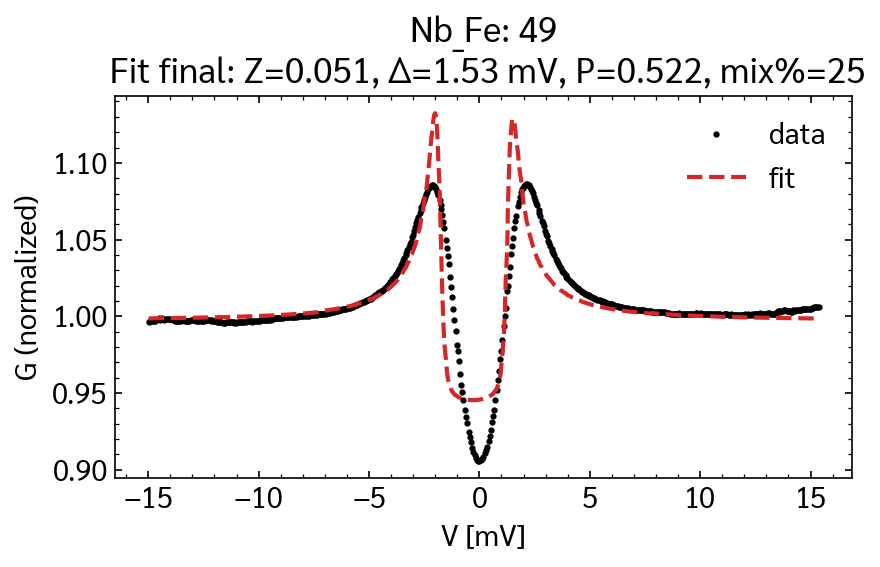

In [ ]:
fit_btk('49', Fe_dir, therm=True)
# plt.savefig('49_therm.png')

In [ ]:
datas = [['# name', 'therm', 'Z', 'Delta', 'P', 'mix']]
dupka = [0.1, 0.2, 0.3, 0.4]
for d in range(5):
  datas.append(['dupa', 'dupaa', dupka[0], dupka[1], dupka[2], dupka[3]])

print(datas)
# datas = np.array(datas)
np.savetxt('dupa.dat', datas, delimiter=',', fmt='%s')

[['# name', 'therm', 'Z', 'Delta', 'P', 'mix'], ['dupa', 'dupaa', 0.1, 0.2, 0.3, 0.4], ['dupa', 'dupaa', 0.1, 0.2, 0.3, 0.4], ['dupa', 'dupaa', 0.1, 0.2, 0.3, 0.4], ['dupa', 'dupaa', 0.1, 0.2, 0.3, 0.4], ['dupa', 'dupaa', 0.1, 0.2, 0.3, 0.4]]


In [ ]:
def plot_files(dir, figs_dir, therm=False):
    os.makedirs(figs_dir, exist_ok=True)

    datas = [['# Name', 'Therm', 'Z', 'Delta', 'P', 'mix']]

    for filename in os.listdir(dir):
      print(f"Processing file: {filename}")
      base_filename = os.path.splitext(filename)[0]

      popt = fit_btk(filename, folder=dir, therm=therm)

      output_filename = f"{base_filename}{'_therm' if therm else ''}.png"
      output_path = os.path.join(figs_dir, output_filename)

      plt.savefig(output_path)
      plt.close()
      print(f"Plot saved to: {output_path}")

      datas.append([filename, therm, popt[0], popt[1], popt[2], popt[3]])

    save_file_path = os.path.join(figs_dir, f'{dir[-5:]}_{therm}.dat')
    np.savetxt(save_file_path, datas, delimiter=',', fmt='%s')

In [ ]:
Fe_figs_dir = os.path.join(data_dir, 'Fe_figs')
Cu_figs_dir = os.path.join(data_dir, 'Cu_figs')

In [ ]:
plot_files(Fe_dir, Fe_figs_dir, therm=False)

Processing file: 31
Global guess: Z=0.000, Δ=1.46 mV, P=0.580, mix%=0.168
Fit final: Z=0.000, Δ=1.46 mV, P=0.580, mix%=0.168


/tmp/ipython-input-10-984199548.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(V*1e3, Gfit, '-', lw=2, label='fit', color='tab:red', linestyle='--')


Plot saved to: /content/drive/MyDrive/Nano_projekt/Fe_figs/31.png
Processing file: 8
Global guess: Z=0.064, Δ=1.60 mV, P=0.488, mix%=0.206
Fit final: Z=0.064, Δ=1.60 mV, P=0.488, mix%=0.206
Plot saved to: /content/drive/MyDrive/Nano_projekt/Fe_figs/8.png
Processing file: 5
Global guess: Z=0.033, Δ=1.51 mV, P=0.452, mix%=0.177
Fit final: Z=0.033, Δ=1.51 mV, P=0.452, mix%=0.177
Plot saved to: /content/drive/MyDrive/Nano_projekt/Fe_figs/5.png
Processing file: 72
Global guess: Z=0.050, Δ=1.38 mV, P=0.523, mix%=0.129
Fit final: Z=0.050, Δ=1.38 mV, P=0.523, mix%=0.129
Plot saved to: /content/drive/MyDrive/Nano_projekt/Fe_figs/72.png
Processing file: 25
Global guess: Z=0.000, Δ=1.46 mV, P=0.557, mix%=0.142
Fit final: Z=0.000, Δ=1.46 mV, P=0.557, mix%=0.142
Plot saved to: /content/drive/MyDrive/Nano_projekt/Fe_figs/25.png
Processing file: 30
Global guess: Z=0.000, Δ=1.44 mV, P=0.575, mix%=0.188
Fit final: Z=0.000, Δ=1.44 mV, P=0.575, mix%=0.188
Plot saved to: /content/drive/MyDrive/Nano_projek

In [ ]:
plot_files(Fe_dir, Fe_figs_dir, therm=True)

Processing file: 31
Global guess: Z=0.000, Δ=1.65 mV, P=0.585, mix%=0.250
Fit final: Z=0.000, Δ=1.65 mV, P=0.585, mix%=0.250


/tmp/ipython-input-10-984199548.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(V*1e3, Gfit, '-', lw=2, label='fit', color='tab:red', linestyle='--')


Plot saved to: /content/drive/MyDrive/Nano_projekt/Fe_figs/31_therm.png
Processing file: 8
Global guess: Z=0.000, Δ=1.77 mV, P=0.501, mix%=0.250
Fit final: Z=0.000, Δ=1.77 mV, P=0.501, mix%=0.250
Plot saved to: /content/drive/MyDrive/Nano_projekt/Fe_figs/8_therm.png
Processing file: 5
Global guess: Z=0.068, Δ=1.76 mV, P=0.451, mix%=0.247
Fit final: Z=0.068, Δ=1.76 mV, P=0.451, mix%=0.247
Plot saved to: /content/drive/MyDrive/Nano_projekt/Fe_figs/5_therm.png
Processing file: 72
Global guess: Z=0.030, Δ=1.60 mV, P=0.543, mix%=0.249
Fit final: Z=0.030, Δ=1.60 mV, P=0.543, mix%=0.249
Plot saved to: /content/drive/MyDrive/Nano_projekt/Fe_figs/72_therm.png
Processing file: 25
Global guess: Z=0.000, Δ=1.72 mV, P=0.555, mix%=0.250
Fit final: Z=0.000, Δ=1.72 mV, P=0.555, mix%=0.250
Plot saved to: /content/drive/MyDrive/Nano_projekt/Fe_figs/25_therm.png
Processing file: 30
Global guess: Z=0.000, Δ=1.60 mV, P=0.580, mix%=0.210
Fit final: Z=0.000, Δ=1.60 mV, P=0.580, mix%=0.210
Plot saved to: /con

In [ ]:
plot_files(Cu_dir, Cu_figs_dir, therm=False)

Processing file: 39norm
Global guess: Z=0.126, Δ=2.55 mV, P=0.403, mix%=0.214
Fit final: Z=0.126, Δ=2.55 mV, P=0.403, mix%=0.214


/tmp/ipython-input-10-984199548.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(V*1e3, Gfit, '-', lw=2, label='fit', color='tab:red', linestyle='--')


Plot saved to: /content/drive/MyDrive/Nano_projekt/Cu_figs/39norm.png
Processing file: 52norm
Global guess: Z=0.057, Δ=1.61 mV, P=0.453, mix%=0.182
Fit final: Z=0.057, Δ=1.61 mV, P=0.453, mix%=0.182
Plot saved to: /content/drive/MyDrive/Nano_projekt/Cu_figs/52norm.png
Processing file: 22norm
Global guess: Z=0.084, Δ=1.72 mV, P=0.432, mix%=0.119
Fit final: Z=0.084, Δ=1.72 mV, P=0.432, mix%=0.119
Plot saved to: /content/drive/MyDrive/Nano_projekt/Cu_figs/22norm.png
Processing file: 27norm
Global guess: Z=0.054, Δ=1.35 mV, P=0.444, mix%=0.194
Fit final: Z=0.054, Δ=1.35 mV, P=0.444, mix%=0.194
Plot saved to: /content/drive/MyDrive/Nano_projekt/Cu_figs/27norm.png
Processing file: 40norm
Global guess: Z=0.119, Δ=2.49 mV, P=0.427, mix%=0.209
Fit final: Z=0.119, Δ=2.49 mV, P=0.427, mix%=0.209
Plot saved to: /content/drive/MyDrive/Nano_projekt/Cu_figs/40norm.png
Processing file: 50norm
Global guess: Z=0.127, Δ=1.90 mV, P=0.435, mix%=0.130
Fit final: Z=0.127, Δ=1.90 mV, P=0.435, mix%=0.130
Plot 

In [ ]:
plot_files(Cu_dir, Cu_figs_dir, therm=True)

Processing file: 39norm
Global guess: Z=0.109, Δ=2.53 mV, P=0.419, mix%=0.112
Fit final: Z=0.109, Δ=2.53 mV, P=0.419, mix%=0.112


/tmp/ipython-input-10-984199548.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(V*1e3, Gfit, '-', lw=2, label='fit', color='tab:red', linestyle='--')


Plot saved to: /content/drive/MyDrive/Nano_projekt/Cu_figs/39norm_therm.png
Processing file: 52norm
Global guess: Z=0.000, Δ=1.57 mV, P=0.465, mix%=0.249
Fit final: Z=0.000, Δ=1.57 mV, P=0.465, mix%=0.249
Plot saved to: /content/drive/MyDrive/Nano_projekt/Cu_figs/52norm_therm.png
Processing file: 22norm
Global guess: Z=0.089, Δ=1.80 mV, P=0.436, mix%=0.135
Fit final: Z=0.089, Δ=1.80 mV, P=0.436, mix%=0.135
Plot saved to: /content/drive/MyDrive/Nano_projekt/Cu_figs/22norm_therm.png
Processing file: 27norm
Global guess: Z=0.063, Δ=1.35 mV, P=0.444, mix%=0.244
Fit final: Z=0.063, Δ=1.35 mV, P=0.444, mix%=0.244
Plot saved to: /content/drive/MyDrive/Nano_projekt/Cu_figs/27norm_therm.png
Processing file: 40norm
Global guess: Z=0.072, Δ=2.19 mV, P=0.455, mix%=0.103
Fit final: Z=0.072, Δ=2.19 mV, P=0.455, mix%=0.103
Plot saved to: /content/drive/MyDrive/Nano_projekt/Cu_figs/40norm_therm.png
Processing file: 50norm
Global guess: Z=0.093, Δ=1.89 mV, P=0.460, mix%=0.149
Fit final: Z=0.093, Δ=1.89

In [ ]:
V_check = np.linspace(0, 0.5, 200)

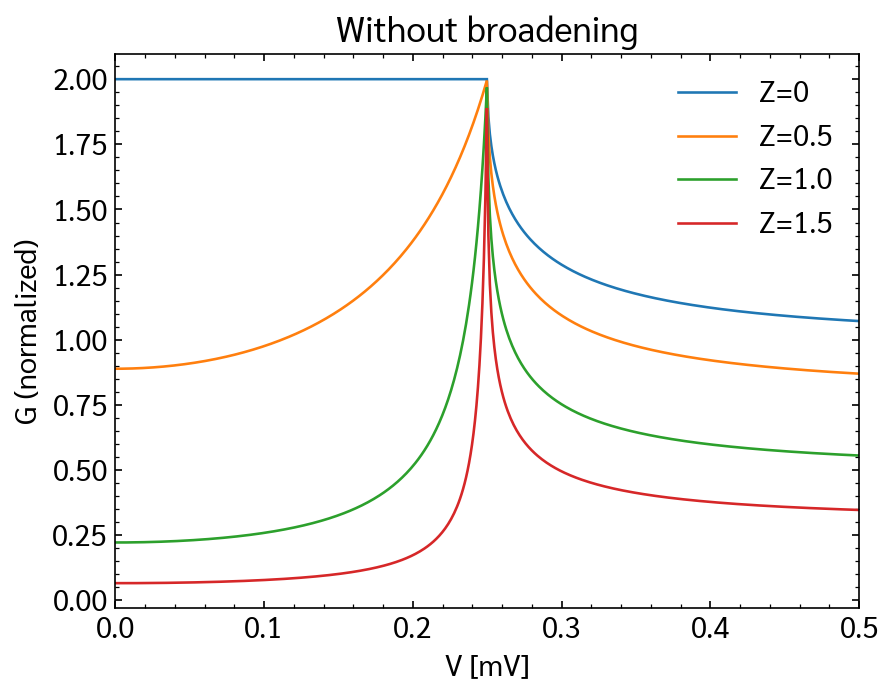

In [ ]:
# polarized_conductance(V, Z, Delta, P):
V_check = np.linspace(-0.5, 0.5, 1000)
V = V_check
Delta = 0.25

for Z in [0,0.5,1.0,1.5]:
  G_calc = polarized_conductance(V, Z, Delta, 0, 0.2, therm=False)
  # G_calc = fermi_dirac(V_check, G_calc)
  plt.plot(V_check, G_calc, label=f'Z={Z}')
# plt.ylim(0.2, 2.5)
plt.legend(loc='upper right')
plt.xlabel('V [mV]')
plt.ylabel('G (normalized)')
plt.title('Without broadening')
plt.xlim([0, 0.5])
plt.show()

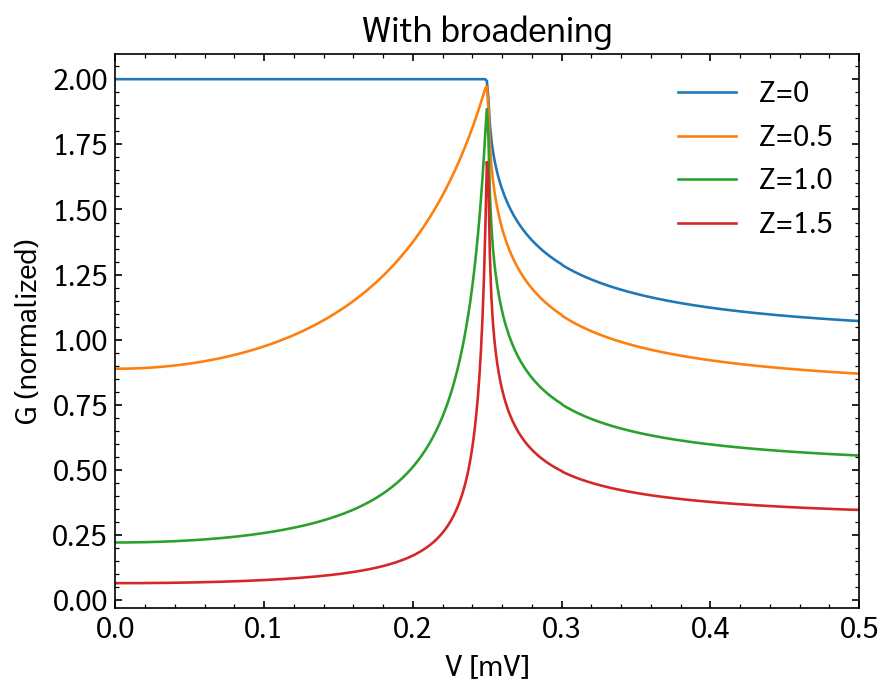

In [ ]:
# polarized_conductance(V, Z, Delta, P):
V_check = np.linspace(-0.5, 0.5, 1000)
V = V_check
Delta = 0.25

for Z in [0,0.5,1.0,1.5]:
  G_calc = polarized_conductance(V, Z, Delta, 0, 0.2, therm=True)
  # G_calc = fermi_dirac(V_check, G_calc)
  plt.plot(V_check, G_calc, label=f'Z={Z}')
# plt.ylim(0.2, 2.5)
plt.legend(loc='upper right')
plt.xlabel('V [mV]')
plt.ylabel('G (normalized)')
plt.title('With broadening')
plt.xlim([0, 0.5])
plt.show()

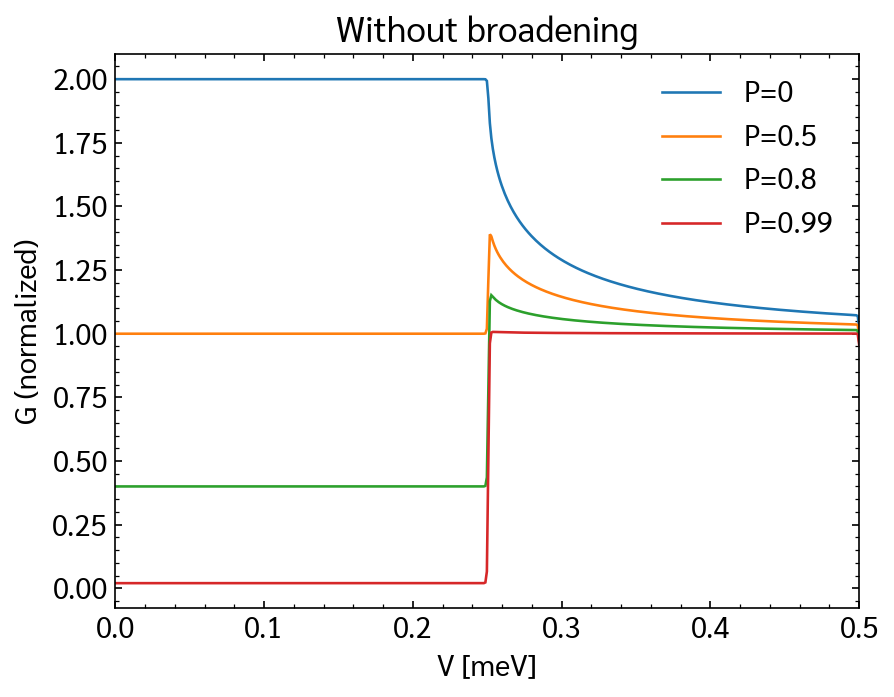

In [ ]:
# polarized_conductance(V, Z, Delta, P):
V_check = np.linspace(-0.5, 0.5, 1000)
Delta = 0.25

for P in [0,0.5,0.8,0.99]:
  G_calc = polarized_conductance(V_check, 0, Delta, P, 0.2, therm=False)
  G_calc = fermi_dirac(V_check, G_calc)
  plt.plot(V_check, G_calc, label=f'P={P}')
# plt.ylim(0.2, 2.5)
plt.legend(loc='upper right')
plt.xlabel('V [meV]')
plt.ylabel('G (normalized)')
plt.title('Without broadening')
plt.xlim([0, 0.5])
plt.show()

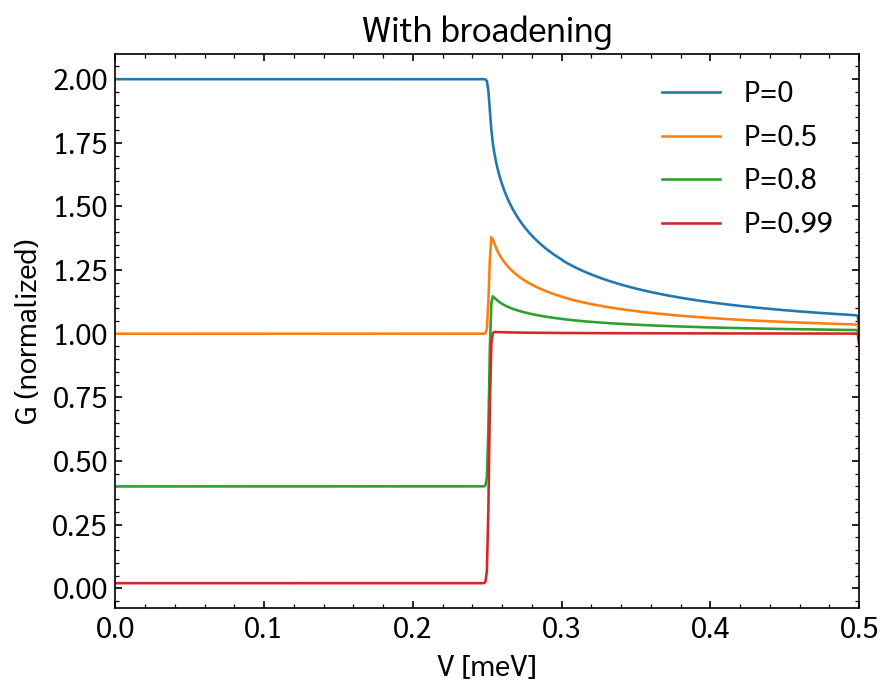

In [ ]:
# polarized_conductance(V, Z, Delta, P):
V_check = np.linspace(-0.5, 0.5, 1000)
Delta = 0.25

for P in [0,0.5,0.8,0.99]:
  G_calc = polarized_conductance(V_check, 0, Delta, P, 0.2, therm=True)
  G_calc = fermi_dirac(V_check, G_calc)
  plt.plot(V_check, G_calc, label=f'P={P}')
# plt.ylim(0.2, 2.5)
plt.legend(loc='upper right')
plt.xlabel('V [meV]')
plt.ylabel('G (normalized)')
plt.title('With broadening')
plt.xlim([0, 0.5])
plt.show()

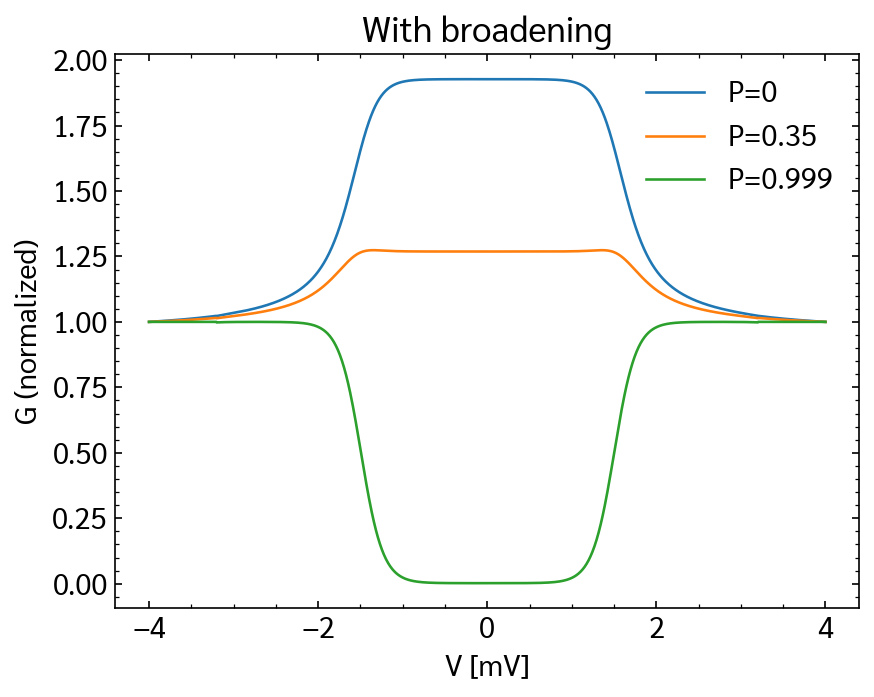

In [ ]:
# polarized_conductance(V, Z, Delta, P):
V_check = np.linspace(-4e-3, 4e-3, 1000)
Delta = 1.5e-3

for P in [0,0.35,0.999]:
  G_calc = polarized_conductance(V_check, 0, Delta, P, 0.1, therm=True)
  G_calc = G_calc/G_calc[-1]
  plt.plot(V_check*1e3, G_calc, label=f'P={P}')
# plt.ylim(0.2, 2.5)
plt.legend(loc='upper right')
plt.xlabel('V [mV]')
plt.ylabel('G (normalized)')
plt.title('With broadening')
# plt.xlim([0, 0.5])
plt.show()

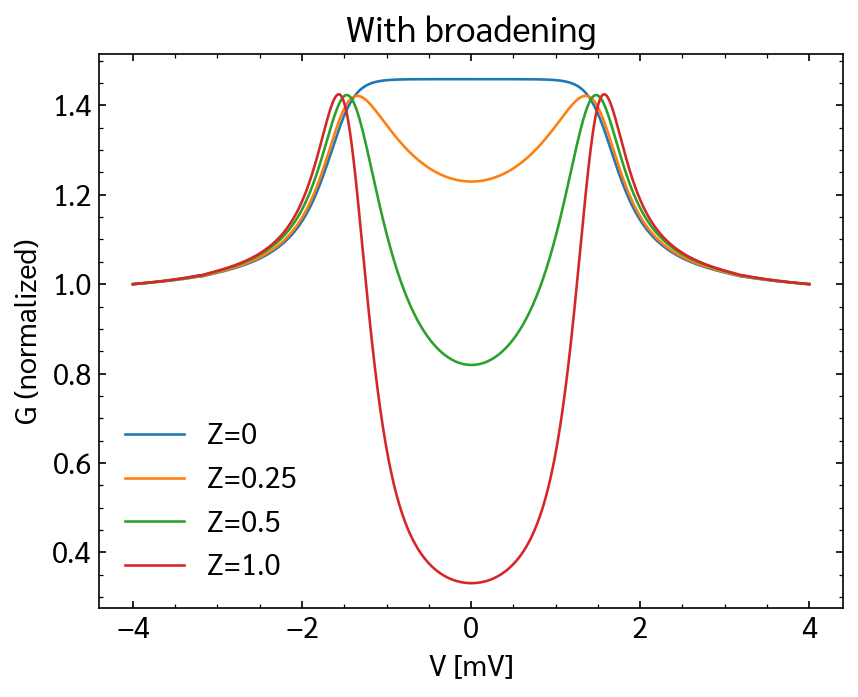

In [ ]:
# polarized_conductance(V, Z, Delta, P):
V_check = np.linspace(-4e-3, 4e-3, 1000)
Delta = 1.5e-3

for Z in [0,0.25,0.5,1.]:
  G_calc = polarized_conductance(V_check, Z, Delta, 0.25, 0.1, therm=True)
  G_calc = G_calc/G_calc[-1]
  plt.plot(V_check*1e3, G_calc, label=f'Z={Z}')
# plt.ylim(0.2, 2.5)
plt.legend(loc='best')
plt.xlabel('V [mV]')
plt.ylabel('G (normalized)')
plt.title('With broadening')
# plt.xlim([0, 0.5])
plt.show()

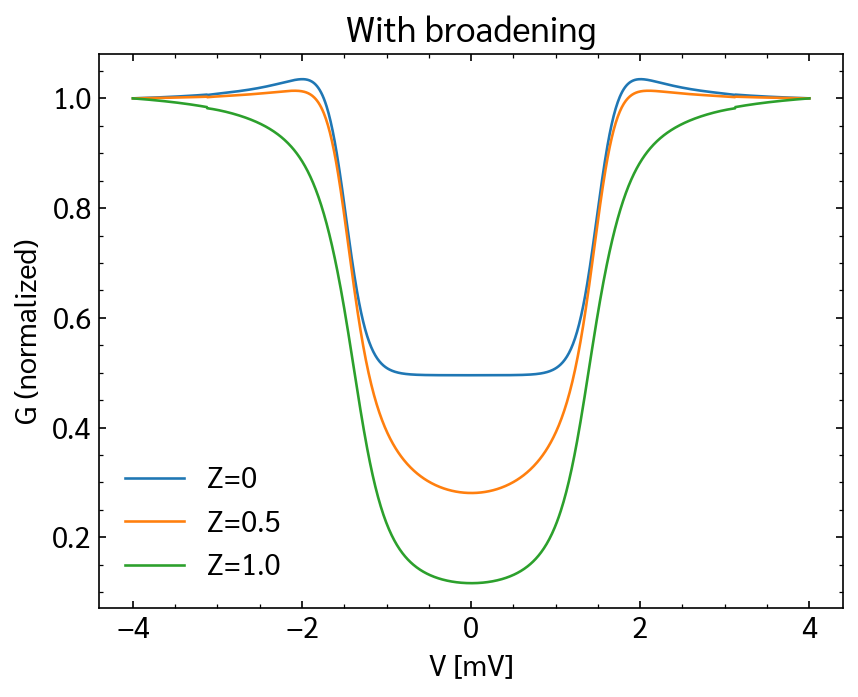

In [ ]:
# polarized_conductance(V, Z, Delta, P):
V_check = np.linspace(-4e-3, 4e-3, 1000)
Delta = 1.5e-3

for Z in [0,0.5,1.]:
  G_calc = polarized_conductance(V_check, Z, Delta, 0.75, 0.11, therm=True)
  G_calc = G_calc/G_calc[-1]
  plt.plot(V_check*1e3, G_calc, label=f'Z={Z}')
# plt.ylim(0.2, 2.5)
plt.legend(loc='best')
plt.xlabel('V [mV]')
plt.ylabel('G (normalized)')
plt.title('With broadening')
# plt.xlim([0, 0.5])
plt.show()